# Unplugged: Predicting the projections of global greenhouse gas emissions from asset-level electricity generation 

#### Group 30 - DS3000 Final Project
#### Heidi Eren, Emma Assiradoo, Tzu-En Huang, Ryan Chan 
#### Source: [Climate TRACE](https://climatetrace.org/explore)

## Executive Summary

The UN states that 35% of total emissions are a result of the energy supply sector, a category that includes electricity as its main component [3]. The energy sector is the largest contributor to total greenhouse gas emissions, yet power is rarely mentioned as the root of the climate change issue. We are all cognizant of global warming, yet unknowing of contributors ranging from manufacturing to agriculture to forestry and land use. In fact, a national study stated that 63% of Americans did not understand why global warming was happening, with many of them having gaps and misconceptions about the topic [1]. There is a need to not only be able to raise awareness of the impacts that climate change can have on the future, but to also highlight and predict the effects of commonly overlooked contributors. By looking at various factors such as the country, asset type, and emission capacity, we wanted to determine whether these factors can accurately predict emissions quantity from electricity generation, or if a large factor of randomness accounts for it. Thus, we trained a model to predict the carbon dioxide emissions quantity on the asset-level, and determined whether these factors are significant with a feature importance plot. Through the model, we also determined which assets are projected to produce the highest greenhouse gas emissions from electricity generation, potentially causing the most damage to our environment.

## Introduction

### Defining the problem

The problem we are trying to solve isn’t just climate change, but to increase the awareness of sectors that are the main contributors to greenhouse gas (GHG) emissions. About ⅔ of carbon emissions can be attributed to the burning of fossil fuels in order to generate electricity and other sources of power (2). In the long run, the consequences resulting from the high carbon footprint will redefine the environment we live in, as it would lead to a reduction in freshwater availability, increase water stress, and contribute to heavy precipitation (4). However, these important facts are often overlooked on social media or in our education system, causing people to simply believe that “plastic waste” is the only factor in climate change. 

### Motivation for the topic

We chose this topic out of an effort to learn more about the roots of climate change, and be able to use predictive modeling to gauge the severity and urgency of the issue at hand. We want to create something that is relevant and applicable where we can spread awareness of the increase in greenhouse gas (GHG) emissions. Although it may not be obvious to an individual, climate change “is seen throughout every aspect of the world we live in” (5) from natural disasters to impacts on human health and infrastructure. 

### Goals & Objectives

There is a general lack of understanding as to the driving forces behind climate change. Our goal is to hone in on the power sector, determining the impact the factors above have on the larger issue at hand. Through the creation of predictive models and data visualizations, we want to be able to increase the digestibility of this information to the general public, showing historical patterns and using those to help predict future outcomes. Our model will enable us to account for r squared, giving us the ability to determine whether randomness or defined factors have more of an impact on carbon emissions. From there we will work to see if, given an asset, we can predict emission amounts with significant accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Methodology

We will be evaluating data from Climate Trace’s [“Power”](https://climatetrace.org/downloads) data. Within the ‘Power’ folder, there are subfiles that contain electricity generation emissions based on asset and country. We will be analyzing ‘asset_electricity-generation_emissions.csv’ to narrow down our focus to the annual electricity generation emissions of asset-level sectors across nations. It contains the total generation of global fossil fuel (and operational) plants for each asset, which was defined at the level of individual power plants. We selected the global emissions at the asset-level because we wanted to observe and explore what specific power plants are contributing the most to global carbon emissions and how we can leverage this insight to make meaningful predictions and raise concerns toward these sectors.

### Data acquisition

Our dataset contains 8.8k asset-level electricity carbon emissions across the globe (The size of this dataset is 20 columns x 8821 rows). The columns include the original inventory sector, start and end times, gas type, emission factors, capacity/capacity units, activity/activity units, asset name, asset type, and coordinates. Climate TRACE utilizes AI and machine learning to analyze 300+ satellites and 11k sensors data to calculate greenhouse gas emissions from electricity generation.

In [3]:
df = pd.read_csv('asset_electricity-generation_emissions.csv', parse_dates = True)
df.head()

,asset_id,iso3_country,original_inventory_sector,start_time,end_time,temporal_granularity,gas,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_units,capacity_factor,activity,activity_units,created_date,modified_date,asset_name,asset_type,st_astext
0,1670320,USA,electricity-generation,2020-01-01 00:00:00,2020-12-31 00:00:00,annual,co2,6853000.0,0.934,tonnes_gas_per_MWh,1717,PP_max_capacity(MW),0.487,7339000,generation_MWh,2022-09-01 16:53:38.166045,NaN,Mill Creek (KY),coal,POINT(-85.9103 38.0525)
1,1670320,USA,electricity-generation,2020-01-01 00:00:00,2020-12-31 00:00:00,annual,ch4,NaN,NaN,tonnes_gas_per_MWh,1717,PP_max_capacity(MW),0.487,7339000,generation_MWh,2022-09-01 16:53:38.166045,NaN,Mill Creek (KY),coal,POINT(-85.9103 38.0525)
2,1670320,USA,electricity-generation,2020-01-01 00:00:00,2020-12-31 00:00:00,annual,n2o,NaN,NaN,tonnes_gas_per_MWh,1717,PP_max_capacity(MW),0.487,7339000,generation_MWh,2022-09-01 16:53:38.166045,NaN,Mill Creek (KY),coal,POINT(-85.9103 38.0525)
3,1670320,USA,electricity-generation,2020-01-01 00:00:00,2020-12-31 00:00:00,annual,co2e_100yr,6853000.0,NaN,tonnes_gas_per_MWh,1717,PP_max_capacity(MW),0.487,7339000,generation_MWh,2022-09-01 16:53:38.166045,NaN,Mill Creek (KY),coal,POINT(-85.9103 38.0525)
4,1670320,USA,electricity-generation,2021-01-01 00:00:00,2021-12-31 00:00:00,annual,ch4,NaN,NaN,tonnes_gas_per_MWh,1717,PP_max_capacity(MW),0.541,8133000,generation_MWh,2022-09-01 16:53:38.166045,NaN,Mill Creek (KY),coal,POINT(-85.9103 38.0525)


In [4]:
df.shape

(8820, 20)

In [5]:
df.describe(include='all')

,asset_id,iso3_country,original_inventory_sector,start_time,end_time,temporal_granularity,gas,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_units,capacity_factor,activity,activity_units,created_date,modified_date,asset_name,asset_type,st_astext
count,8.820000e+03,8820,8820,8820,8820,8820,8820,5.576000e+03,1764.000000,8820,8820.000000,8820,8820.000000,8.820000e+03,8820,8820,5092,8820,8820,8820
unique,NaN,45,1,3,3,1,5,NaN,NaN,1,NaN,1,NaN,NaN,1,969,79,601,29,601
top,NaN,CHN,electricity-generation,2020-01-01 00:00:00,2020-12-31 00:00:00,annual,co2,NaN,NaN,tonnes_gas_per_MWh,NaN,PP_max_capacity(MW),NaN,NaN,generation_MWh,2022-09-01 16:53:38.166045,2022-10-03 21:51:06.994252,Mill Creek (KY),coal,POINT(-85.9103 38.0525)
freq,NaN,4120,8820,2965,2965,8820,1764,NaN,NaN,8820,NaN,8820,NaN,NaN,8820,15,100,15,7175,15
mean,3.546798e+06,NaN,NaN,NaN,NaN,NaN,NaN,9.279217e+06,0.916896,NaN,2393.867347,NaN,0.531127,1.088867e+07,NaN,NaN,NaN,NaN,NaN,NaN
std,4.319643e+06,NaN,NaN,NaN,NaN,NaN,NaN,5.108457e+06,0.176038,NaN,1179.084387,NaN,0.100366,5.303391e+06,NaN,NaN,NaN,NaN,NaN,NaN
min,1.669940e+06,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.363000,NaN,430.000000,NaN,0.169000,1.218000e+06,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.670088e+06,NaN,NaN,NaN,NaN,NaN,NaN,6.212750e+06,0.897000,NaN,1440.000000,NaN,0.471000,7.072500e+06,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.670237e+06,NaN,NaN,NaN,NaN,NaN,NaN,8.226000e+06,0.897000,NaN,2060.000000,NaN,0.553000,9.579000e+06,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.670388e+06,NaN,NaN,NaN,NaN,NaN,NaN,1.122900e+07,0.937000,NaN,2822.000000,NaN,0.583000,1.312550e+07,NaN,NaN,NaN,NaN,NaN,NaN


### Preliminary Data Visualizations 

Prior to cleaning the data, we wanted to explore and understand the data we have in preparation for analysis. We created a heatmap to help visually display the correlation between the variables in the columns that we decided to focus on. Heatmaps display a measure of dependency based on color. In our heatmap, the darker the color, the higher the correlation. As you can see from the heatmap below, there was a linear and strong correlation between certain variables. 

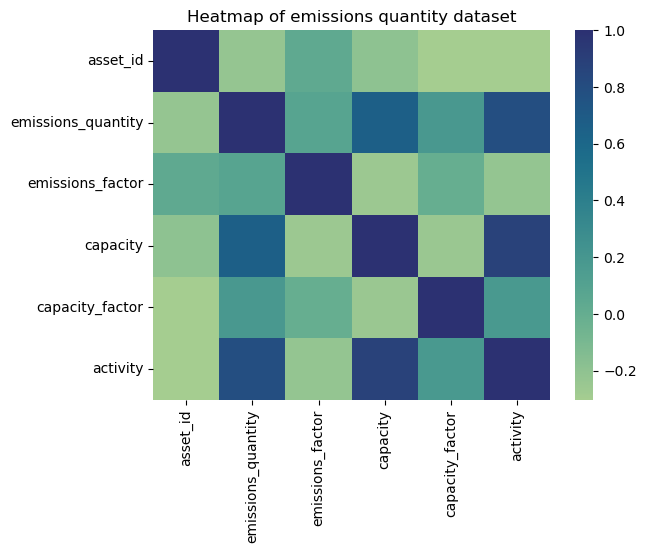

In [6]:
cor = df.corr(numeric_only = True)
sns.heatmap(cor, cmap="crest")
plt.title('Heatmap of emissions quantity dataset')
plt.show()

### Data Preparation - EDA

Prior to analyzing the data, we must perform the necessary steps to clean the data. It was expected that there would be empty values for some of the categories since not all information about an asset may be known.

Steps to take:
- Replace all NaN or missing values with 0 and remove unnecessary columns (that we felt do not affect emissions quantity)
- Change the datatype of features accordingly
- Drop duplicate emission quantities (gas labelled co2_20yr and co2_100yr have the same values as the co2) and select only the co2 gas type emissions

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8820 entries, 0 to 8819
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   asset_id                   8820 non-null   int64  
 1   iso3_country               8820 non-null   object 
 2   original_inventory_sector  8820 non-null   object 
 3   start_time                 8820 non-null   object 
 4   end_time                   8820 non-null   object 
 5   temporal_granularity       8820 non-null   object 
 6   gas                        8820 non-null   object 
 7   emissions_quantity         5576 non-null   float64
 8   emissions_factor           1764 non-null   float64
 9   emissions_factor_units     8820 non-null   object 
 10  capacity                   8820 non-null   int64  
 11  capacity_units             8820 non-null   object 
 12  capacity_factor            8820 non-null   float64
 13  activity                   8820 non-null   int64

In [8]:
# see if any columns have null values
df.isnull().sum()

asset_id                        0
iso3_country                    0
original_inventory_sector       0
start_time                      0
end_time                        0
temporal_granularity            0
gas                             0
emissions_quantity           3244
emissions_factor             7056
emissions_factor_units          0
capacity                        0
capacity_units                  0
capacity_factor                 0
activity                        0
activity_units                  0
created_date                    0
modified_date                3728
asset_name                      0
asset_type                      0
st_astext                       0
dtype: int64

In [9]:
# true is the number of NaN values
df['emissions_factor'].isnull().value_counts()

True     7056
False    1764
Name: emissions_factor, dtype: int64

In [10]:
# true is the number of NaN values
df['modified_date'].isnull().value_counts()

False    5092
True     3728
Name: modified_date, dtype: int64

Since majority of the emission factor values for each asset are unknown, we will remove this column entirely. The start time, end time, created date, modified date, and coordinates are also not relevant in predicting the emission quantities, so we will remove them as well. The units for each of the features were redundant, so they were removed too. 

In [11]:
df = df.drop(['emissions_factor', 'start_time', 'end_time', 'created_date', 'modified_date', 'st_astext'], axis=1)

In [12]:
df = df.drop(['emissions_factor_units', 'capacity_units', 'activity_units', 'temporal_granularity', 'original_inventory_sector'], axis=1)

With the remaining features in the dataframe, we will convert them into the appropriate data types.

In [13]:
# convert variables to the correct data type
df['iso3_country'] = df['iso3_country'].astype('string')
df['asset_name'] = df['asset_name'].astype('string')
df['asset_type'] = df['asset_type'].astype('string')
df['capacity'] = df['capacity'].astype('Int64')
df['gas'] = df['gas'].astype('string')

In [14]:
# should have dtype of float
df['capacity_factor'].value_counts()

0.612    605
0.568    600
0.574    560
0.523    220
0.553    205
        ... 
0.748      5
0.307      5
1.000      5
0.773      5
0.332      5
Name: capacity_factor, Length: 386, dtype: int64

In [15]:
# check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8820 entries, 0 to 8819
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asset_id            8820 non-null   int64  
 1   iso3_country        8820 non-null   string 
 2   gas                 8820 non-null   string 
 3   emissions_quantity  5576 non-null   float64
 4   capacity            8820 non-null   Int64  
 5   capacity_factor     8820 non-null   float64
 6   activity            8820 non-null   int64  
 7   asset_name          8820 non-null   string 
 8   asset_type          8820 non-null   string 
dtypes: Int64(1), float64(2), int64(2), string(4)
memory usage: 628.9 KB


In [16]:
df['gas'].value_counts()

co2           1764
ch4           1764
n2o           1764
co2e_100yr    1764
co2e_20yr     1764
Name: gas, dtype: Int64

In [17]:
# select only the co2 gas type emissions
df = df[df.gas == 'co2']
df.head()

,asset_id,iso3_country,gas,emissions_quantity,capacity,capacity_factor,activity,asset_name,asset_type
0,1670320,USA,co2,6853000.0,1717,0.487,7339000,Mill Creek (KY),coal
9,1670378,IND,co2,5769000.0,1340,0.523,6156000,Khaperkheda power station,coal
13,1670378,IND,co2,6083000.0,1340,0.553,6491000,Khaperkheda power station,coal
18,1670378,IND,co2,6259000.0,1340,0.569,6679000,Khaperkheda power station,coal
25,1670107,IND,co2,10623000.0,2340,0.553,11336000,Kahalgaon Super Thermal Power Plant,coal


In [18]:
# check for nan values
df.isnull().sum()

asset_id              0
iso3_country          0
gas                   0
emissions_quantity    0
capacity              0
capacity_factor       0
activity              0
asset_name            0
asset_type            0
dtype: int64

## Data Visualizations

To visualize the data, we wanted to inspect the target variable, emissions quantity, across the dataset. 

### Emissions Quantity by Assets

First, we made a bar graph of the top five assets producing the highest emissions quantities. Notice how the emission quantity is 10^7 tonnes of co2 gas, which goes to show the magnitude of values that the dataset contains.

In [19]:
# df from high emission groupby 
high_em = df.groupby(['asset_id', 'iso3_country', 'asset_name'])['emissions_quantity'].mean().reset_index()
# df from high emission groupby top 5
high_em5 = df.groupby(['asset_id', 'iso3_country', 'asset_name'])['emissions_quantity'].mean().reset_index().head(5)

In [20]:
high_em5['emissions_quantity'].value_counts()

3.439500e+07    1
3.350033e+07    1
3.298433e+07    1
2.427467e+07    1
2.329867e+07    1
Name: emissions_quantity, dtype: int64

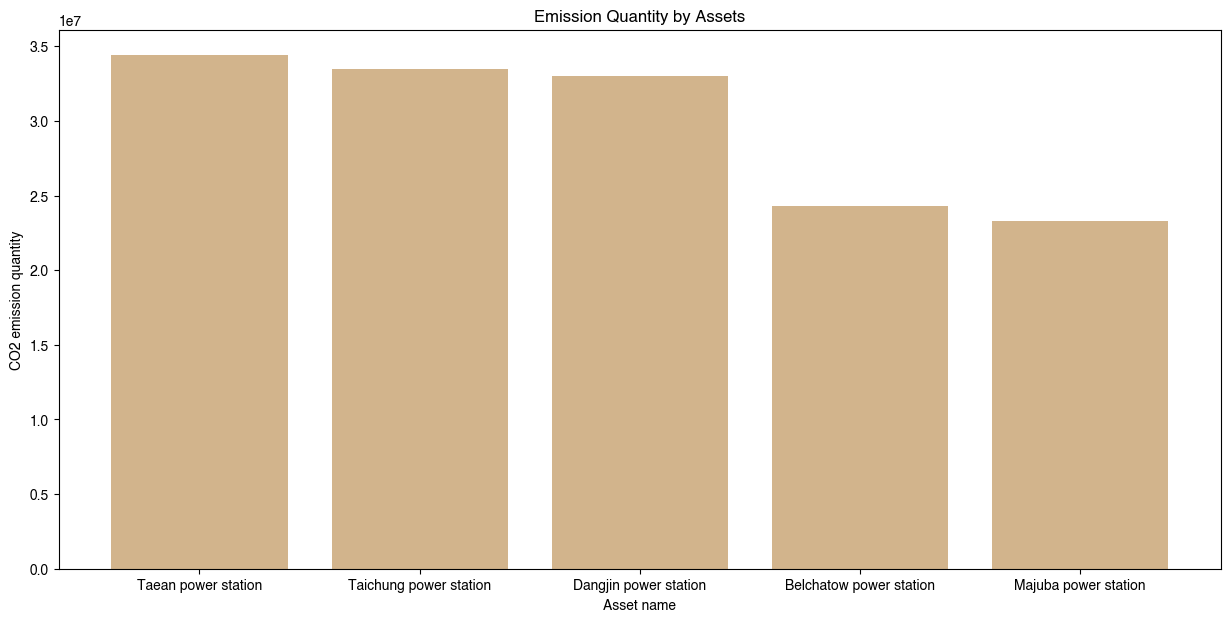

In [21]:
# graph emission qauntity by assets
fig = plt.figure(figsize =(15, 7))
plt.bar(high_em5['asset_name'], high_em5['emissions_quantity'], color = 'tan')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

plt.title('Emission Quantity by Assets')
plt.ylabel('CO2 emission quantity')
plt.xlabel('Asset name')
plt.show()


### Emissions Quantity by Country

Next, we made a bar graph that depicts the top 10 emission quantities produced by country.

/var/folders/yl/3zqq2j6j49nb0w3cpkr4pyv00000gn/T/ipykernel_17058/2836228415.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


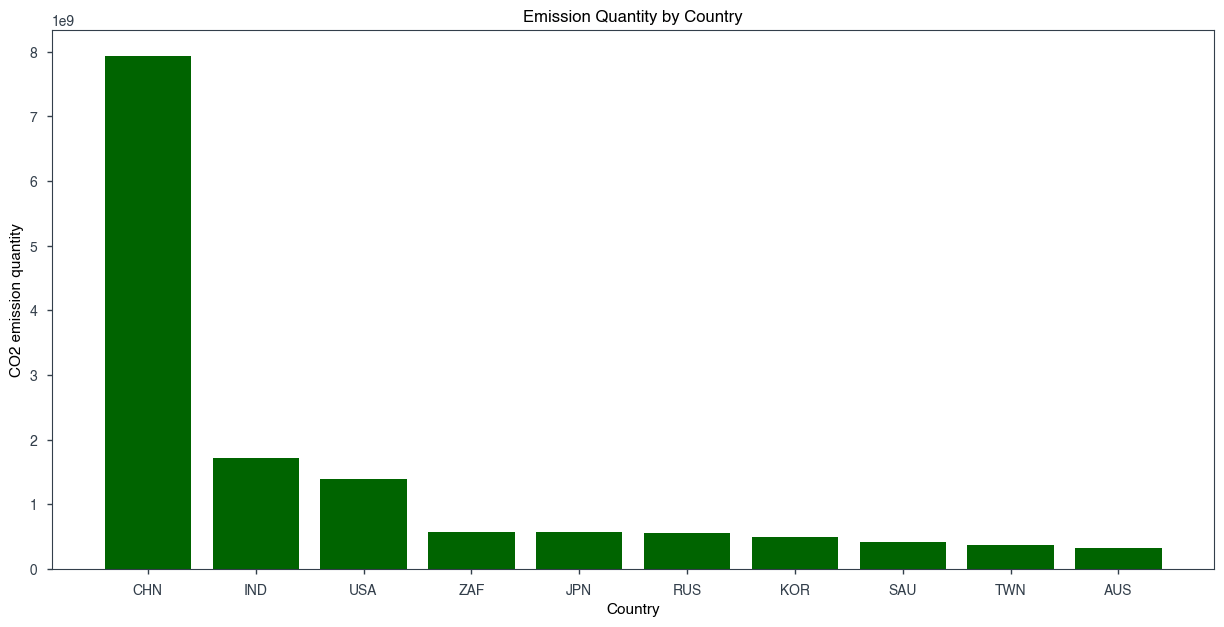

In [22]:
# graph emission quantity by country
country_em = df.groupby(['iso3_country'])['emissions_quantity'].sum().reset_index().sort_values(by = 'emissions_quantity', ascending = False)
country_em10 = country_em.head(10)

plt.style.use('seaborn-notebook')
fig = plt.figure(figsize =(15, 7))
plt.bar(country_em10['iso3_country'], country_em10['emissions_quantity'], color = ['darkgreen'])

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

plt.title('Emission Quantity by Country')
plt.ylabel('CO2 emission quantity')
plt.xlabel('Country')
plt.show()

## Related Work

There are two related pieces of work that we found were helpful in providing a guideline for creating our own model.  

**Can Machine Learning be Applied to Carbon Emissions Analysis** focused on the carbon emissions from China using the Gaussian Process Regression and compared the results of that algorithm compared to more traditional methods such as the linear  regression model. In this study we saw that it was very rigid and provided an overfitting problem when predicting emissions. This study shows us an example of the difference in results based on our data features [9]. 

**Predicting the Environmental Change of Carbon Emission Patterns in South Asia** shared a similar goal with the study above. However, this study used several more advanced methods not covered in this course such as LSTM and BiLSSTM. It demonstrated the benefits of these models and helped us focus on mimicking the features of these models to make our model more accurate [10]. 

## Model Selection

Looking at previous studies related to the prediction of carbon emissions from different asset types, we determined that common algorithms used were Random Forest, Support Vector Machine(SVM), and Decision Tree regression models. Thus, we tested these three models on the dataset with hypertuned parameters (determined by testing a range of values for each parameter) to explore the strengths and weaknesses of each algorithm. 

To evaluate the performance of each model, the mean score of the estimator, R-squared score (coefficient of determination), was obtained through the best_score_ value.

In [23]:
# want to predict emissions quantity w/model
emissions = 'emissions_quantity'
# assign numeric
num_features = ['capacity', 'capacity_factor', 'activity']
# assign categorical
cat_features = ['iso3_country', 'asset_type']

In [24]:
# create train and test data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [25]:
# create standard scaler object
standardize_num = StandardScaler()
# use one hot encoder for categorical
standardize_cat = OneHotEncoder(handle_unknown='ignore')

In [26]:
# use column transformer w/ numeric + categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', standardize_num, num_features),
        ('cat', standardize_cat, cat_features)])

In [27]:
# fit + transform training data w/ all columns
X_train = preprocessor.fit_transform(train_df[num_features + cat_features])
y_train = train_df[emissions]

In [28]:
# fit + transform test data w/ all columns
X_test = preprocessor.transform(test_df[num_features + cat_features])
y_test = test_df[emissions]

### Decision Tree

In [29]:
#make a decision tree w/ training data
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_params = {'max_depth': [1, 2, 3, 4, 5]}
dt_gridsearch = GridSearchCV(dt_regressor, dt_params, cv=5, return_train_score=True)
dt_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5]},
             return_train_score=True)

In [30]:
#for decision tree, print best estimator + best score
print("Decision Tree Regressor:")
print("Best model:", dt_gridsearch.best_estimator_)
print("Best score:", dt_gridsearch.best_score_)

Decision Tree Regressor:
Best model: DecisionTreeRegressor(max_depth=5, random_state=42)
Best score: 0.9161172822561318


### Support Vector Machine (SVM)

In [31]:
#use SVR object to do SVM evaluatuon w/ training data
svm_regressor = SVR(kernel='rbf')
svm_params = {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001]}
svm_gridsearch = GridSearchCV(svm_regressor, svm_params, cv=5, return_train_score=True)
svm_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001]},
             return_train_score=True)

In [32]:
#for SVM, print best estimator + best score
print("Support Vector Regressor:")
print("Best model:", svm_gridsearch.best_estimator_)
print("Best score:", svm_gridsearch.best_score_)

Support Vector Regressor:
Best model: SVR(C=100, gamma=0.1)
Best score: -0.08093498680156234


### Random Forest

Our final decision in model selection was based on a continuous and numerical data type, the emissions quantity. After testing various models with optimal parameter values through GridSearchCV, the one that fit the best in terms of best score and accuracy was the **Random Forest Tree Regressor**. With our dataset having a large number of features and the limited need for non-linear evaluation (kernel trick), random forest produced more accurate results and was more suitable to train our model. With numerical features such as capacity, capacity factor, and activity of greenhouse gas emissions and categorical features such as country and asset type (of which we utilized OneHotEncoder), we applied ColumnTransformer to train the data through separate transformers based on the feature type. This created the training set and testing set. The random forest regressor was initialized with a random_state of 42, which ensures the same train and test sets were obtained across different executions. We then selected the most optimal hyper-tuned parameters through GridSearchCV() by testing a range of parameter values for n_estimators and max_depth. After fitting the training set into the model, the best parameters and the best score value were outputted. 

In [33]:
# create random forest regressor w/ training data
rf_regressor = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [1, 2, 3, 4, 5]}
rf_gridsearch = GridSearchCV(rf_regressor, rf_params, cv=5, return_train_score=True)
rf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True)

In [34]:
# for random forest, print best estimator + best score
print("Random Forest Regressor:")
print("Best model:", rf_gridsearch.best_estimator_)
print("Best score:", rf_gridsearch.best_score_)
print("Best n_estimators value:", rf_gridsearch.best_params_['n_estimators'])

Random Forest Regressor:
Best model: RandomForestRegressor(max_depth=5, random_state=42)
Best score: 0.9333958429249318
Best n_estimators value: 100


## Results & Evaluation

By testing the range of hypertuning parameters for the random forest regression model, the most optimal parameters were selected through GridSearch cross validation. The best ‘n_estimators’ value was 100 (the number of decision trees in the random forest), ‘max_depth’ value was 5 (the number of levels in each decision tree), and ‘random_state’ was 42. These parameters ensured the model avoided overfitting or underfitting the training sets, while retaining a level of complexity.

From our analysis of factors like country, gas, asset name and overall activity, we were able to predict with high likelihood what the emissions for a given region would be. In order to find the model with the highest accuracy we judged the best scores of SVM, Random Forest, and Decision Tree regressor models, ultimately concluding that Random Forest model would yield the best results, with a best score of around 0.9334. The model performed fairly well in predicting the emissions quantity. We used best_score_ from sklearn to measure our models due to the fact that it obtains the best hyperparameters over all cross-validation folds using the mean score of the best estimators. With a best score of 0.9334, we can conclude that given the factors of asset id, country, gas, capacity, capacity factor, activity, asset name, and asset type to produce a model that explains 93.34% of the variance in emissions quantity.

In [35]:
y_pred_rf = rf_gridsearch.predict(X_test)
print('The predicted carbon emission is: {}'.format(y_pred_rf))
print('The accuracy of the model is: {}'.format(rf_gridsearch.score(X_test, y_test)))

mse = mean_squared_error(y_test, y_pred_rf)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse))

The predicted carbon emission is: [16392908.0793573   8777191.34149601  5846174.42658383  8938690.2810138
 11112987.04136257 17661340.64186871  6031386.92766477 12263867.55584129
  7984008.61175096  9699803.45266598  6031386.92766477 10011527.77270278
  7074579.60475507  5644052.12189797 11093488.98941451  8607543.69258447
  6031386.92766477  6031386.92766477  9948213.68158998  9909875.08623722
  7943194.52843117  6031386.92766477  9597235.43393416  7695210.47013279
  6031386.92766477  6031386.92766477 30240854.00676937  7943194.52843117
  5862376.40060981 12381492.83116883  6031386.92766477  3559809.59866556
  6724258.69590682  7527083.60688011  3805221.32567971 13997450.51571029
  7429203.5038627   6298776.41050902  6031386.92766477 10308510.45762716
  8378029.67996867  6031386.92766477  7870543.7963042   7469214.65195204
  6039943.4088655   9512110.44968034 12249672.30526971  6031386.92766477
 18233498.1005873  19101428.24049337 11031319.96479406 19452308.39419711
  6031386.92766477

In [36]:
# display the cv results for the train and test set
cv_results = pd.DataFrame(rf_gridsearch.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

,mean_train_score,std_train_score,mean_test_score,std_test_score
12,0.966575,0.000868,0.933396,0.009995
14,0.966426,0.000617,0.932945,0.010254
13,0.966437,0.000625,0.932373,0.010087
9,0.943631,0.002481,0.911891,0.014927
11,0.943449,0.002030,0.911461,0.014887


There is slight discrepancy between the best mean train score and mean test score as well as the standard deviation scores. There may be slight overfitting with less variance and more bias, which suggests the bias-variance problems influenced the accuracy of the model. 

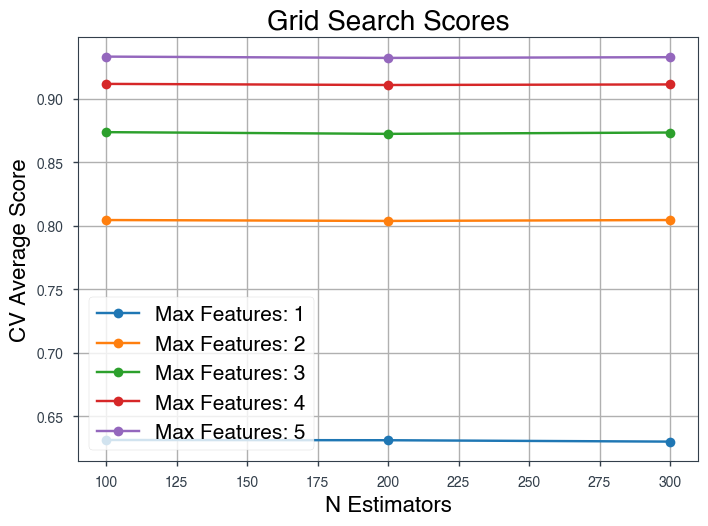

In [37]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    """ plot GridSearchCV results into graph
    """
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

plot_grid_search(rf_gridsearch.cv_results_, list(rf_params.values())[0], list(rf_params.values())[1], 'N Estimators', 'Max Features')

We created a GridSearchCV values graph to demonstrate the various parameters tested for each model above. Notice how the n_estimators were the same across 100 to 300, which shows how any of those values would create the most optimal model. 

Next, we wanted to display the top assets predicted to produce the highest quantity of emissions, and compare it to the current emissions quantity produced.

In [38]:
# Make predictions on the emission quantity
y_pred = rf_gridsearch.predict(X_test)

# Add the predicted emissions as a new column to the original dataset
test_df['predicted_emissions'] = y_pred

# Group the data by asset and sum the predicted emissions over the time period of interest
asset_emissions = test_df.groupby('asset_id')['predicted_emissions'].sum()

# Sort the assets by their total predicted emissions in descending order
asset_emissions = asset_emissions.sort_values(ascending=False)

# Print the top 10 assets with the highest predicted emissions
print(asset_emissions.head(10))

asset_id
1669942    9.501407e+07
1670074    3.786119e+07
1669983    3.667122e+07
1669951    3.633264e+07
1670011    3.352931e+07
1669940    3.313848e+07
1669941    3.312298e+07
1669976    3.230784e+07
1669971    2.988459e+07
1670005    2.593764e+07
Name: predicted_emissions, dtype: float64


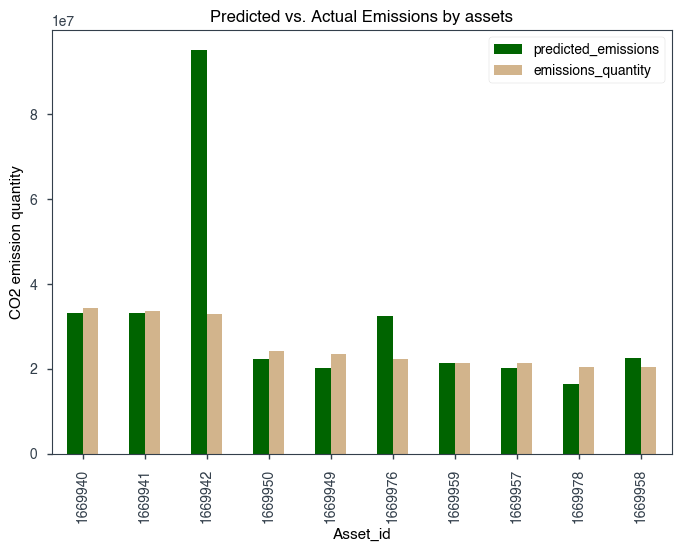

In [39]:
pred_actual = asset_emissions.to_frame().merge(high_em.set_index('asset_id'), left_index = True, right_index = True).reset_index()
pred_actual_10= pred_actual.sort_values(by = 'emissions_quantity', ascending = False).head(10)

pred_actual_10.plot(x = 'asset_id', y = ['predicted_emissions', 'emissions_quantity'], kind = 'bar', color = ['darkgreen', 'tan'])

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

plt.title('Predicted vs. Actual Emissions by assets')
plt.ylabel('CO2 emission quantity')
plt.xlabel('Asset_id')
plt.show()


We furthermore wanted to utilize our model to determine which assets have the largest overall impact on our environment with regard to emissions quantity, a goal that we were able to accomplish as displayed above. Although the majority of assets are predicted to produce slightly less emissions than what is being produced right now, there are other assets that spike in the predicted production of carbon emissions. Looking at the emissions quantity by country, these assets can be associated with the countries producing the top carbon dioxide emissions. 

## Impacts

Our project could be of interest to a wide audience ranging from policymakers to individuals. Carbon analysis has become very important in the past few decades as issues of global warming have emerged as a serious problem. Our analysis of the predictability of carbon emissions could serve as an example of the reliability of CO2 predictions. Carbon emissions predictions can be used for several different reasons: 

1. First, it can help support mitigation and preventive efforts that locate the highest emitting sources. Carbon emissions are the leading cause of global warming and it is of utmost importance to pinpoint carbon trends. By doing so, reduction efforts can be put in place to prevent increasing emissions and hopefully work towards carbon neutrality. 
2. Secondly, individuals can benefit from our solution. Predicting carbon emissions can raise awareness and educate the public about the impact of their actions on the environment. It can encourage individuals to take responsibility and make changes in their behavior to reduce their carbon footprint. 
3. Finally, the biggest impact our solution has is on businesses and industries. Businesses can benefit by using predictions to find inefficiencies in their business and make improvements that will lower their costs, prioritize actions, and measure the impact of their intervention. This could also serve businesses well creating positive public exposure. While some businesses can benefit from our model, there will also be some that are negatively impacted by our findings. Businesses that are dependent on fossil fuels or have histories of high carbon emissions could be negatively impacted after our findings would cast a spotlight over the environmental harm they create. These businesses could potentially be forced to adhere to new policies, face public scrutiny, and lose profits. With carbon emission predictions having such a large impact on such a large audience, our model serves as justification for the accuracy of CO2 predictions.

## Conclusion

Through this project, we were able to analyze the relationship between “emissions_quantity” and different features like “capacity”, “activity”, “capacity_factor”, and “country”. We wanted to determine whether carbon emission quantity is predictable by those features. To further support our overall goal we also evaluated which assets are projected to produce the highest emissions quantity. Prior to our prediction model, we tried to understand which country had the most carbon emission as well as which specific asset had the most emission. We were able to explore these areas by looking at the existing data and group by assets or country to look at their emissions as a whole. Some realizations include China being the country that had the most emitted CO2 while Korea had two major power plants that emitted the most carbon emission. These findings help us evaluate the overall trend in carbon emissions across the globe. Then, with our Random Forest Regression model, we were able to predict the emission quantity of an asset based on the location, the capacity of the asset, and the ongoing activity in the power plant. Our model stands with an accuracy score of 0.93, which shows that our model has very high model accuracy and it’s an appropriate model for this training and testing datasets. However, our model lacks in model performance with the unreasonably high mean square errors it presents. 

There are many areas of improvements that can be made to enhance the predictability of our model. First, there are a lot of other factors that could influence carbon emissions of power plants, and the dataset had a limited and insufficient amount of features which led to the instability of our model performance. The model performance could be enhanced if we had explored other related datasets and combined them to have more features of selections. Another aspect we could improve on was to increase the amount of data or have a higher quality dataset that had less invalid or null values that prevented us from using it. These changes could allow us to have a better model that predicts carbon emissions, and can provide positive impacts to increasing awareness of the key contributors of carbon emissions.

## Works Cited

1. “Americans' Knowledge of Climate Change.” Yale Program on Climate Change Communication, 29 Feb. 2016, https://climatecommunication.yale.edu/publications/americans-knowledge-of-climate-change/. 
2. “Climate Change Impacts.” National Oceanic and Atmospheric Administration, 31 Aug. 2021, https://www.noaa.gov/education/resource-collections/climate/climate-change-impacts#:~:text=The%20impacts%20of%20climate%20change%20on%20different%20sectors%20of%20society,availability%2C%20and%20limit%20worker%20productivity. 
3. Energy and Climate Change — European Environment Agency. Energy and Climate Change, 11 May 2021, https://www.eea.europa.eu/signals/signals-2017/articles/energy-and-climate-change. 
4. “Facts and Figures.” United Nations, United Nations, https://www.un.org/en/actnow/facts-and-figures#:~:text=The%20energy%20supply%20sector%20. 
5. “What Are the Long-Term Effects of Climate Change?” What Are the Long-Term Effects of Climate Change? | U.S. Geological Survey, https://www.usgs.gov/faqs/what-are-long-term-effects-climate-change#:~:text=Scientists%20have%20predicted%20that%20long,resources%20in%20semi%2Darid%20regions.
6. Alova, G., Trotter, P.A. & Money, A. A machine-learning approach to predicting Africa’s electricity mix based on planned power plants and their chances of success. Nat Energy 6, 158–166 (2021). https://doi.org/10.1038/s41560-020-00755-9
7. Krechowicz, Adam & Krechowicz, Maria & Poczeta, Katarzyna. (2022). Machine Learning Approaches to Predict Electricity Production from Renewable Energy Sources. Energies. 15. 9146. 10.3390/en15239146. 
8. Kim S-G, Jung J-Y, Sim MK. A Two-Step Approach to Solar Power Generation Prediction Based on Weather Data Using Machine Learning. Sustainability. 2019; 11(5):1501. https://doi.org/10.3390/su11051501
9. Ma, Ning, et al. “Can Machine Learning Be Applied to Carbon Emissions Analysis: An Application to the CO2 Emissions Analysis Using Gaussian Process Regression.” Frontiers, Frontiers, 8 Sept. 2021, https://www.frontiersin.org/articles/10.3389/fenrg.2021.756311/full. 
10. Aamir, Muhammad, et al. “Predicting the Environmental Change of Carbon Emission Patterns in South Asia: A Deep Learning Approach Using Bilstm.” MDPI, Multidisciplinary Digital Publishing Institute, 30 Nov. 2022, https://www.mdpi.com/2073-4433/13/12/2011. 